In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *


import scipy


In [6]:
PRE_INTERVAL = 1000
POST_INTERVAL = 1000
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "StimOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
matplotlib.rcParams.update({'font.size': 12})


In [3]:
pairs = pd.read_pickle("/data/patrick_res/sessions/pairs_at_least_3blocks_7sess.pickle")
pairs = pairs.reset_index(drop=True)

In [4]:
within_dim_accs = []
across_dim_accs = []
overall_accs = []
for (feat1, feat2) in pairs.pair.values:
    within_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_confidence_fixed_StimOnset_pair_{feat1}_{feat2}_within_dim_accs.npy"))
    across_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_confidence_fixed_StimOnset_pair_{feat1}_{feat2}_across_dim_accs.npy"))
    overall_acc = np.load(os.path.join(OUTPUT_DIR, f"confidence_overall_StimOnset_pair_{feat1}_{feat2}_test_accs.npy"))
    within_dim_accs.append(within_dim_acc)
    across_dim_accs.append(across_dim_acc)
    overall_accs.append(overall_acc)
within_dim_accs = np.hstack(within_dim_accs)
across_dim_accs = np.hstack(across_dim_accs)
overall_accs = np.hstack(overall_accs)

Text(0.5, 0, 'Time Relative to Stimulus Onset (s)')

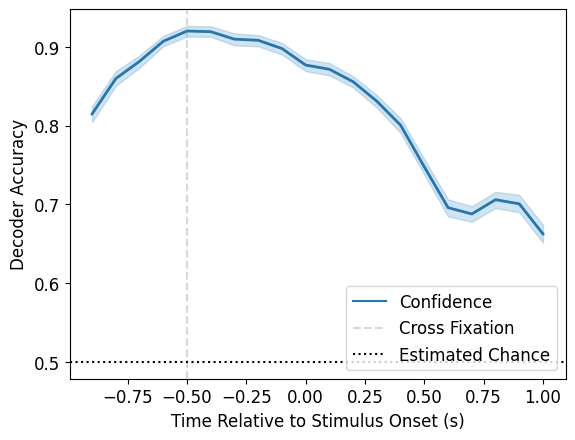

In [7]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn(
    [overall_accs], 
    ["Confidence"], 
    PRE_INTERVAL, INTERVAL_SIZE, ax)
ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cross Fixation")

# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Stimulus Onset (s)")


Text(0.5, 0, 'Time Relative to Stimulus Onset (s)')

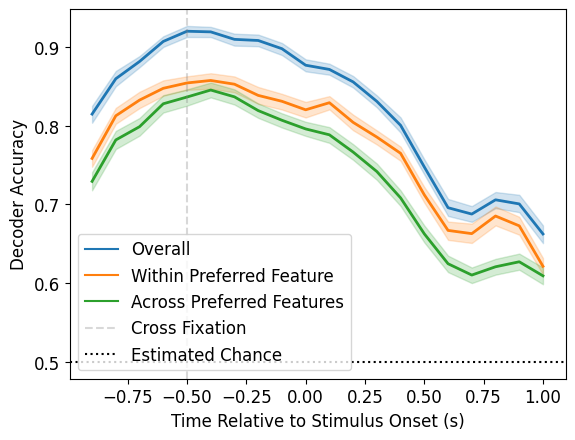

In [8]:
fig, ax = plt.subplots()
visualization_utils.plot_accs_seaborn(
    [overall_accs, within_dim_accs, across_dim_accs, ], 
    ["Overall", "Within Preferred Feature", "Across Preferred Features"], 
    PRE_INTERVAL, INTERVAL_SIZE, ax)
ax.axvline(-0.5, alpha=0.3, color='gray', linestyle='dashed', label="Cross Fixation")
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_ylabel("Decoder Accuracy")
ax.set_xlabel("Time Relative to Stimulus Onset (s)")


### Plot decoder weights

In [65]:
valid_sess = pd.read_pickle(SESSIONS_PATH)
positions = spike_utils.get_unit_positions(valid_sess)
positions = positions.sort_values(by="PseudoUnitID")
positions["np_idx"] = list(range(len(positions)))

In [66]:
all_weights = np.empty((len(positions), len(pairs), 20))
for i, row in pairs.iterrows():
    feat1, feat2 = row.pair
    pair_sessions = row.sessions
    models = np.load(os.path.join(OUTPUT_DIR, f"confidence_overall_StimOnset_pair_{feat1}_{feat2}_models.npy"), allow_pickle=True)
    pair_pos = positions[positions.session.isin(pair_sessions)]
    weights = classifier_utils.evaluate_model_weights_by_time_bins(models, num_neurons=len(pair_pos), num_classes=2)
    all_weights[pair_pos.np_idx.values, i, :] = weights
combined_weights = np.nanmean(all_weights, axis=1)
means = np.mean(combined_weights, axis=1)
means_df = pd.DataFrame({'np_idx': np.arange(len(means)), 'weight': means})

Text(0.5, 0, 'Time Relative to Stimulus Onset (s)')

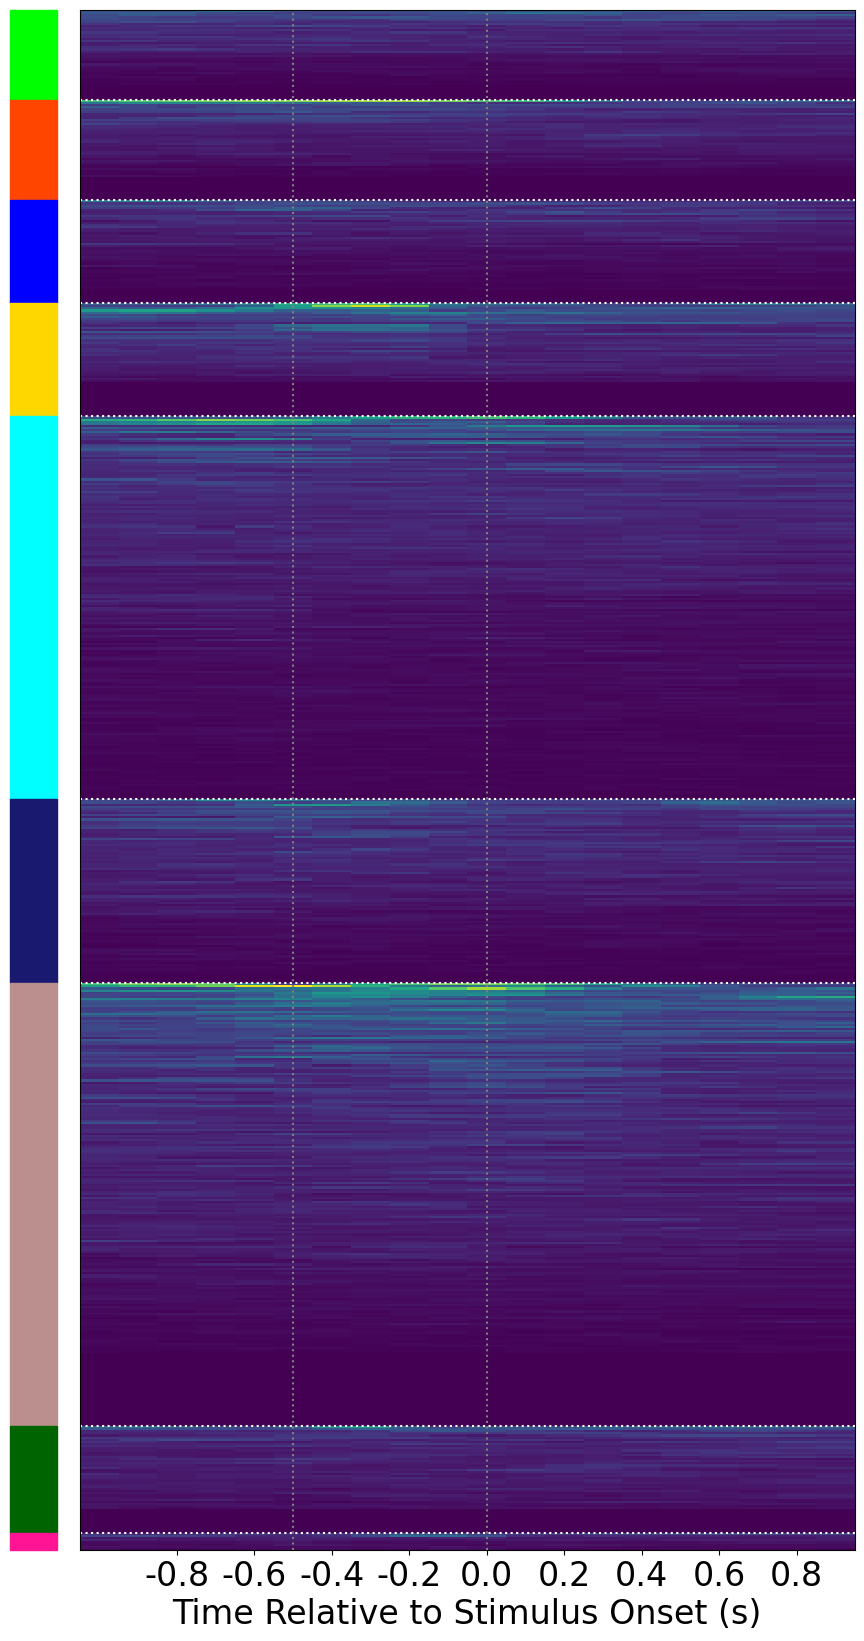

In [75]:
matplotlib.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(10, 20))
positions = spike_utils.get_unit_positions(valid_sess)
visualization_utils.visualize_weights(
    positions, 
    combined_weights, 
    "manual_structure", 
    name_to_color=visualization_utils.REGION_TO_COLOR, 
    add_region=True, 
    mean_weights_df=means_df,
    ax=ax
)
ratio = 10
tick_labels = np.array([-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8])
tick_pos = (tick_labels + 1) * ratio
# fig.colorbar(colors)
# axis = np.arange(0, 28, 3)s
# labels = np.around((axis - 13) * 0.1, 1)
ax.set_xticks(tick_pos)
ax.set_xticklabels(tick_labels)
ax.xaxis.tick_bottom()
ax.axvline(5, color="gray", linestyle="dotted", linewidth=1.5)
ax.axvline(10, color="gray", linestyle="dotted", linewidth=1.5)

ax.set_xlabel("Time Relative to Stimulus Onset (s)")

### What about from the simulated firing rates?

In [6]:
within_dim_accs = np.empty((5, 160))
across_dim_accs = np.empty((5, 160))

for i, noise in enumerate([0.0, 0.1, 0.2, 0.3, 0.4]):
    within_dim_accs_noise = []
    across_dim_accs_noise = []
    for (feat1, feat2) in pairs.pair.values:
        within_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_confidence_simulation_noise_{noise}_pair_{feat1}_{feat2}_within_dim_accs.npy"))
        across_dim_acc = np.load(os.path.join(OUTPUT_DIR, f"ccgp_confidence_simulation_noise_{noise}_pair_{feat1}_{feat2}_across_dim_accs.npy"))
        within_dim_accs_noise.append(within_dim_acc)
        across_dim_accs_noise.append(across_dim_acc)
    within_dim_accs_noise = np.hstack(within_dim_accs_noise)
    across_dim_accs_noise = np.hstack(across_dim_accs_noise)
    within_dim_accs[i, :] = within_dim_accs_noise
    across_dim_accs[i, :] = across_dim_accs_noise


Text(0, 0.5, 'Decoder Accuracy')

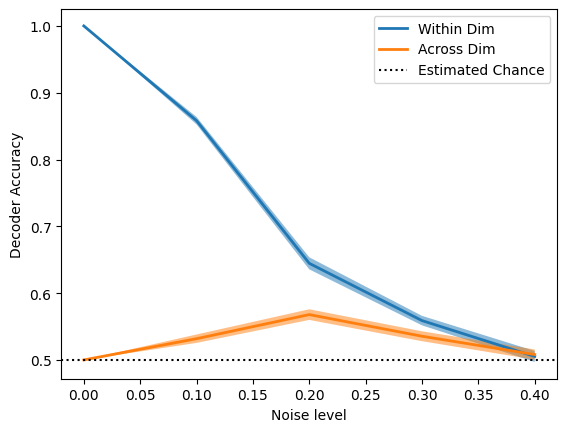

In [8]:
fig, ax = plt.subplots()
visualization_utils.visualize_accuracy_across_time_bins(
    within_dim_accs,
    0, 0.5, 0.1,  # by default these are in seconds
    ax,
    label=f"Within Dim",
    # right_align=True, 
    sem=True,
)
visualization_utils.visualize_accuracy_across_time_bins(
    across_dim_accs,
    0, 0.5, 0.1,  # by default these are in seconds
    ax,
    label=f"Across Dim",
    # right_align=True, 
    sem=True,
)

# # add grey band for selection period
# ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# # add dotted line for feedback start
# # add estimated chance
ax.axhline(1/2, color='black', linestyle='dotted', label="Estimated Chance")
ax.legend()
ax.set_xlabel("Noise level")
ax.set_ylabel("Decoder Accuracy")